In [4]:
import pandas as pd
import numpy as np
import fastsparsegams
np.random.seed(0)
df = pd.read_csv('./fico_full.csv').sample(frac=1, random_state=0)

In [5]:
df = df[df.columns[-10:]]

In [29]:
for c in df.columns:
    print(f"Missing rate for {c}", df[df[c] == -7].shape[0] / df[c].shape[0])

Missing rate for PercentTradesWBalance 0.0
Missing rate for ExternalRiskEstimate 0.0
Missing rate for MSinceOldestTradeOpen 0.0
Missing rate for MSinceMostRecentTradeOpen 0.0
Missing rate for AverageMInFile 0.0
Missing rate for NumSatisfactoryTrades 0.0
Missing rate for NumTrades60Ever2DerogPubRec 0.0
Missing rate for NumTrades90Ever2DerogPubRec 0.0
Missing rate for PercentTradesNeverDelq 0.0
Missing rate for MSinceMostRecentDelq 0.44608030592734227
Missing rate for MaxDelq2PublicRecLast12M 0.0
Missing rate for MaxDelqEver 0.0
Missing rate for NumTotalTrades 0.0
Missing rate for NumTradesOpeninLast12M 0.0
Missing rate for PercentInstallTrades 0.0
Missing rate for MSinceMostRecentInqexcl7days 0.17801147227533462
Missing rate for NumInqLast6M 0.0
Missing rate for NumInqLast6Mexcl7days 0.0
Missing rate for NetFractionRevolvingBurden 0.0
Missing rate for NetFractionInstallBurden 0.0
Missing rate for NumRevolvingTradesWBalance 0.0
Missing rate for NumInstallTradesWBalance 0.0
Missing rate f

In [6]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=20, stratify=df['PoorRiskPerformance'])

In [7]:
train_df.shape

(8367, 10)

In [9]:
def binarize_according_to_train(train_df, test_df):
    n_train, d_train = train_df.shape
    n_test, d_test = test_df.shape
    train_binned, train_augmented_binned, test_binned, test_augmented_binned = {}, {}, {}, {}
    train_no_missing, test_no_missing = {}, {}
    for c in train_df.columns:
        if c == 'PoorRiskPerformance':
            continue
        for v in list(train_df[c].quantile([0.2, 0.4, 0.6, 0.8, 1]).unique()) + [-7, -8, -9]:
            if v in [-7, -8, -9]:
                new_col_name = f'{c} == {v}'

                new_row_train = np.zeros(n_train)
                new_row_train[train_df[c] == v] = 1
                train_binned[new_col_name] = new_row_train
                train_augmented_binned[new_col_name] = new_row_train
                
                new_row_test = np.zeros(n_test)
                new_row_test[test_df[c] == v] = 1
                test_binned[new_col_name] = new_row_test
                test_augmented_binned[new_col_name] = new_row_test
            else:
                new_col_name = f'{c} <= {v}'

                new_row_train = np.zeros(n_train)
                new_row_train[train_df[c] <= v] = 1
                train_no_missing[new_col_name] = new_row_train
                train_binned[new_col_name] = new_row_train
                train_augmented_binned[new_col_name] = new_row_train
                
                new_row_test = np.zeros(n_test)
                new_row_test[test_df[c] <= v] = 1
                test_no_missing[new_col_name] = new_row_test
                test_binned[new_col_name] = new_row_test
                test_augmented_binned[new_col_name] = new_row_test
    
    for c_outer in train_df.columns:
        if c_outer == 'PoorRiskPerformance':
            continue
        for c_inner in train_df.columns:
            for m_val in [-7, -8, -9]:
                for v in train_df[c_inner].quantile([0.2, 0.4, 0.6, 0.8, 1]).unique():
                    if (v in [-7, -8, -9]) or c_inner == 'PoorRiskPerformance':
                        continue
                    else:
                        new_col_name = f'{c_outer}_missing_{m_val} & {c_inner} <= {v}'

                        new_row_train = np.zeros(n_train)
                        new_row_train[(train_df[c_outer] == m_val) & (train_df[c_inner] <= v)] = 1
                        train_augmented_binned[new_col_name] = new_row_train

                        new_row_test = np.zeros(n_test)
                        new_row_test[(test_df[c_outer] == m_val) & (test_df[c_inner] <= v)] = 1
                        test_augmented_binned[new_col_name] = new_row_test
    train_binned['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_binned['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    train_no_missing['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_no_missing['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    train_augmented_binned['PoorRiskPerformance'] = train_df['PoorRiskPerformance']
    test_augmented_binned['PoorRiskPerformance'] = test_df['PoorRiskPerformance']
    return pd.DataFrame(train_no_missing), pd.DataFrame(train_binned), pd.DataFrame(train_augmented_binned), \
         pd.DataFrame(test_no_missing), pd.DataFrame(test_binned), pd.DataFrame(test_augmented_binned)

In [10]:
train_no_missing, train_binned, train_binned_augmented, test_no_missing, test_binned, test_binned_augmented = binarize_according_to_train(train_df, test_df)

X_indicator_train = train_binned[train_binned.columns[:-1]].values
y_train = train_binned['PoorRiskPerformance'].values

X_indicator_test = test_binned[test_binned.columns[:-1]].values
y_test = test_binned['PoorRiskPerformance'].values

X_no_missing_train = train_no_missing[train_no_missing.columns[:-1]].values
X_no_missing_test = test_no_missing[test_no_missing.columns[:-1]].values

X_aug_train = train_binned_augmented[train_binned_augmented.columns[:-1]].values
X_aug_test = test_binned_augmented[test_binned_augmented.columns[:-1]].values

In [11]:
X_indicator_train.shape

(8367, 67)

In [12]:
X_aug_train.shape

(8367, 1093)

In [13]:
model_no_missing = fastsparsegams.fit(
    X_no_missing_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, algorithm="CDPSI"
)

In [14]:
model_indicator = fastsparsegams.fit(
    X_indicator_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, algorithm="CDPSI"
)

In [15]:
model_aug = fastsparsegams.fit(
    X_aug_train.astype(float), y_train.astype(int)*2 - 1, loss="Exponential", max_support_size=40, algorithm="CDPSI"
)

In [16]:
#recover coefficients and train/test probabilities
def eval_model(model, X_train, X_test, col_names): 
    coeffs = np.zeros((len(model.lambda_0[0]), X_train.shape[1]))
    missing_coeffs = np.zeros((len(model.lambda_0[0])))
    inter_coeffs = np.zeros((len(model.lambda_0[0])))
    train_probs = np.zeros((len(model.lambda_0[0]), X_train.shape[0]))
    test_probs = np.zeros((len(model.lambda_0[0]), X_test.shape[0]))

    for i, lamby in enumerate(model.lambda_0[0]): 
        train_probs[i] = model.predict(X_train.astype(float),lambda_0=lamby).reshape(-1)
        test_probs[i] = model.predict(X_test.astype(float),lambda_0=lamby).reshape(-1)

        cur_col_names = col_names[(model.coeff(lambda_0=lamby).toarray().flatten()[1:] != 0)]
        missing_coeffs[i] = sum(['-' in c for c in cur_col_names])
        inter_coeffs[i] = sum(['&' in c for c in cur_col_names])
        coeffs[i] = (model.coeff(lambda_0=lamby).toarray().flatten())[1:] #first entry is intercept
    return train_probs, test_probs, coeffs, missing_coeffs, inter_coeffs

In [17]:
train_probs_aug, test_probs_aug, coeff_aug, missing_coeff_aug, inter_coeffs = eval_model(model_aug, X_aug_train, 
                                                                            X_aug_test, train_binned_augmented.columns[:-1])
trainacc_aug = ((train_probs_aug > 0.5) == y_train).mean(axis = 1)
testacc_aug = ((test_probs_aug > 0.5) == y_test).mean(axis = 1)
num_terms_aug = (coeff_aug != 0).sum(axis=1)

In [18]:
train_probs_indicator, test_probs_indicator, coeff_indicator, missing_coeff_indicator, _ = eval_model(model_indicator, 
                                                                                                    X_indicator_train, 
                                                                                                    X_indicator_test,
                                                                                                    train_binned.columns[:-1])
trainacc_indicator = ((train_probs_indicator > 0.5) == y_train).mean(axis=1)
testacc_indicator = ((test_probs_indicator > 0.5) == y_test).mean(axis=1)
num_terms_indicator = (coeff_indicator != 0).sum(axis=1)

In [19]:
train_probs_no_missing, test_probs_no_missing, coeff_no_missing, missing_coeff_no_missing, _ = eval_model(model_no_missing, X_no_missing_train, X_no_missing_test, train_no_missing.columns[:-1])
trainacc_no_missing = ((train_probs_no_missing > 0.5) == y_train).mean(axis=1)
testacc_no_missing = ((test_probs_no_missing > 0.5) == y_test).mean(axis=1)
num_terms_no_missing = (coeff_no_missing != 0).sum(axis=1)

In [20]:
print(trainacc_no_missing)

[0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.5219314  0.5219314  0.5219314  0.5219314  0.5219314  0.5219314
 0.63642883 0.63642883 0.63642883 0.63642883 0.63642883 0.63642883
 0.63642883 0.63642883 0.63642883 0.63642883 0.63642883 0.65531254
 0.65531254 0.65387833 0.65387833 0.65387833 0.65387833 0.65387833
 0.66451536 0.66451536 0.66451536 0.66415681 0.66415681 0.66415681
 0.66415681 0.66559101 0.66559101 0.66630812 0.66630812 0.66630812
 0.66642763 0.66750329 0.66738377 0.66738377 0.66738377 0.66738377
 0.66881798 0.66869846 0.66869846 0.66881798 0.66881798 0.66941556
 0.66822039 0.66810087 0.66810087 0.66881798 0.66869846 0.67001315
 0

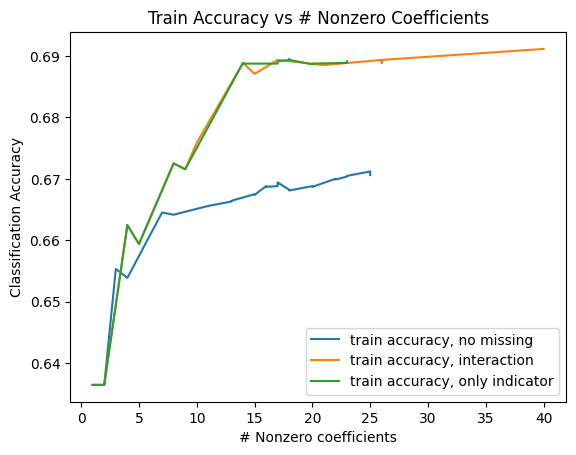

In [21]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Train Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)
plt.plot(num_terms_no_missing[num_terms_no_missing > 0], trainacc_no_missing[num_terms_no_missing > 0], label='train accuracy, no missing')
plt.plot(num_terms_aug[num_terms_aug > 0], trainacc_aug[num_terms_aug > 0], label='train accuracy, interaction')
plt.plot(num_terms_indicator[num_terms_indicator > 0], trainacc_indicator[num_terms_indicator > 0], label='train accuracy, only indicator')
plt.ylabel('Classification Accuracy')
plt.xlabel('# Nonzero coefficients')

plt.legend()

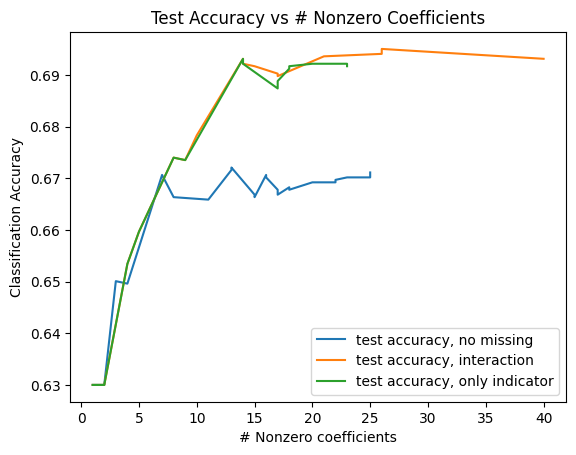

In [22]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Test Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)
plt.plot(num_terms_no_missing[num_terms_no_missing > 0], testacc_no_missing[num_terms_no_missing > 0], label='test accuracy, no missing')
plt.plot(num_terms_aug[num_terms_aug > 0], testacc_aug[num_terms_aug > 0], label='test accuracy, interaction')
plt.plot(num_terms_indicator[num_terms_indicator > 0], testacc_indicator[num_terms_indicator > 0], label='test accuracy, only indicator')
plt.ylabel('Classification Accuracy')
plt.xlabel('# Nonzero coefficients')

plt.legend()

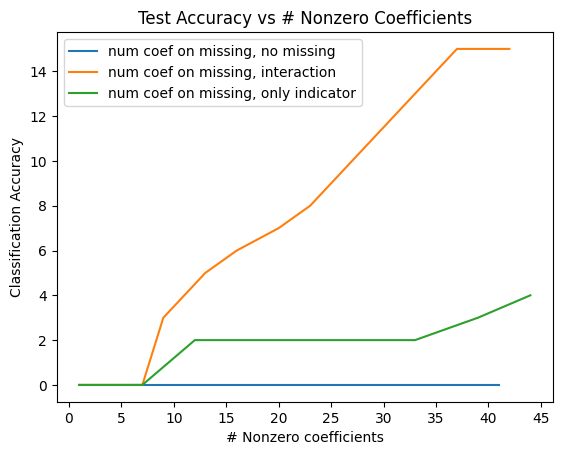

In [63]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Test Accuracy vs # Nonzero Coefficients')#\n (Other than intercept)
plt.plot(num_terms_no_missing[num_terms_no_missing > 0], missing_coeff_no_missing[num_terms_no_missing > 0], label='num coef on missing, no missing')
plt.plot(num_terms_aug[num_terms_aug > 0], missing_coeff_aug[num_terms_aug > 0], label='num coef on missing, interaction')
plt.plot(num_terms_indicator[num_terms_indicator > 0], missing_coeff_indicator[num_terms_indicator > 0], label='num coef on missing, only indicator')
plt.ylabel('Classification Accuracy')
plt.xlabel('# Nonzero coefficients')

plt.legend()

In [26]:
lam = 2

names = train_binned_augmented.columns[:-1][abs(model_aug.coeff(lambda_0=lam).toarray().flatten()[1:]) > 0]
coef_dict = {}
for i, v in enumerate(model_aug.coeff(lambda_0=lam).toarray().flatten()[1:][abs(model_aug.coeff(lambda_0=lam).toarray().flatten()[1:]) > 0]):
    coef_dict[names[i]] = v
#print(names)
print(coef_dict)

{'PercentTradesWBalance <= 43.0': -0.1480838925426495, 'ExternalRiskEstimate <= 68.0': 0.19490262054996862, 'ExternalRiskEstimate <= 74.0': 0.22139898641982267, 'AverageMInFile <= 66.0': 0.1838978902965496, 'AverageMInFile <= 81.0': 0.17571449735990463, 'NumSatisfactoryTrades <= 22.0': 0.16482820666097994, 'PercentTradesNeverDelq <= 94.0': 0.26859398975079946, 'MSinceMostRecentDelq <= 20.0': 0.13625106273192894, 'MaxDelq2PublicRecLast12M <= 4.0': 0.17358334093407393, 'PercentInstallTrades <= 27.0': -0.07721976225170056, 'PercentInstallTrades <= 50.0': -0.2223295328995919, 'MSinceMostRecentInqexcl7days <= 0.0': 0.31205801503931013, 'NumInqLast6M <= 1.0': -0.1539062477111042, 'NetFractionRevolvingBurden <= 36.0': -0.1488218512777065, 'NumRevolvingTradesWBalance <= 4.0': -0.12520139214119036, 'NumBank2NatlTradesWHighUtilization <= 1.0': -0.14871929243437784, 'ExternalRiskEstimate_missing_-9 & MSinceMostRecentTradeOpen <= 7.0': -0.4044440595525021, 'MSinceMostRecentDelq_missing_-7 & Averag

MSinceMostRecentDelq_missing & AverageMInFile is a pretty interesting term -- MSinceMostRecentDelq is Months Since Most Recent Delinquency and AverageMInFile is Average Months in File. So, if somebody has a larger n months in file, it might be more suspicious if the months since delinquency is missing.

In [27]:
names = train_binned.columns[:-1][abs(model_indicator.coeff(lambda_0=lam).toarray().flatten()[1:]) > 0]
coef_dict = {}
for i, v in enumerate(model_indicator.coeff(lambda_0=lam).toarray().flatten()[1:][abs(model_indicator.coeff(lambda_0=lam).toarray().flatten()[1:]) > 0]):
    coef_dict[names[i]] = v
print(len(coef_dict))
#print(names)
print(coef_dict)

18
{'PercentTradesWBalance <= 43.0': -0.23229176242929817, 'ExternalRiskEstimate <= 68.0': 0.1896361862496485, 'ExternalRiskEstimate <= 74.0': 0.29578121974030536, 'MSinceMostRecentTradeOpen <= 7.0': -0.08891434339604014, 'AverageMInFile <= 66.0': 0.18574276663025585, 'AverageMInFile <= 81.0': 0.1963279753418443, 'NumSatisfactoryTrades <= 22.0': 0.16738335680654987, 'PercentTradesNeverDelq <= 94.0': 0.3285590599493666, 'MSinceMostRecentDelq <= 20.0': 0.16570429648197457, 'PercentInstallTrades <= 50.0': -0.2410748280960129, 'MSinceMostRecentInqexcl7days <= 0.0': 0.2752871369148586, 'MSinceMostRecentInqexcl7days == -8': -0.6771655184192313, 'NumInqLast6M <= 1.0': -0.1501536930858762, 'NetFractionRevolvingBurden <= 36.0': -0.17607689900628498, 'NetFractionInstallBurden == -8': 0.10794775255147337, 'NumRevolvingTradesWBalance <= 4.0': -0.14601411317470037, 'NumBank2NatlTradesWHighUtilization <= 0.0': -0.18745461622840492, 'NumBank2NatlTradesWHighUtilization == -8': 0.4136398876617332}


In [46]:
train_binned.columns[:-1][abs(model_indicator.coeff(lambda_0=0.06).toarray().flatten()[1:]) > 0]

Index(['age_y <= 3.3', 'age_y <= 3.6', 'age_y <= 3.9', 'age_y <= 4.2',
       'age_y <= 4.4', 'age_y <= 4.6', 'age_y <= 4.7', 'age_y <= 5.2',
       'age_y <= 5.5', 'age_y <= 5.6', 'age_y <= 6.1', 'age_y <= 6.4',
       'age_y <= 6.5', 'age_y <= 6.8', 'age_y <= 7.1', 'age_y <= 7.3',
       'age_y <= 9.0', 'age_y <= 9.5', 'age_y <= 10.1', 'age_y <= 11.3',
       'age_y <= 12.0', 'age_y <= 12.9', 'pain <= 0.0', 'swollenadp <= 0.0',
       'swollenadp <= 1.0', 'tender <= 0.0', 'tender missing',
       'tonsillarswelling <= 0.0', 'tonsillarswelling <= 1.0',
       'exudate <= 0.0', 'exudate <= 1.0', 'temperature <= 37.9',
       'temperature <= 38.0', 'temperature <= 38.3', 'temperature <= 38.6',
       'temperature <= 38.7', 'temperature <= 38.9', 'temperature <= 39.1',
       'temperature <= 39.5', 'temperature <= 39.9', 'sudden <= 0.0',
       'cough <= 0.0', 'cough <= 1.0', 'rhinorrhea <= 0.0', 'headache <= 0.0',
       'petechiae <= 0.0', 'petechiae <= 1.0', 'abdopain <= 0.0',
       

In [19]:

X_aug_train.shape

(540, 14195)